In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [36]:
def read_cube_file(cube_file):

    f = open(cube_file, 'r')
    title = f.readline()
    comment = f.readline()

    axes = [0, 1, 2]
    line = f.readline().split()
    natoms = int(line[0])

    origin = np.array(line[1:], dtype=float) / ang_2_bohr

    shape = np.empty(3,dtype=int)
    cell = np.empty((3, 3))
    for i in range(3):
        n, x, y, z = [float(s) for s in f.readline().split()]
        shape[i] = int(n)
        cell[i] = n * np.array([x, y, z])

    cell = cell / ang_2_bohr

    numbers = np.empty(natoms, int)
    positions = np.empty((natoms, 3))
    for i in range(natoms):
        line = f.readline().split()
        numbers[i] = int(line[0])
        positions[i] = [float(s) for s in line[2:]]

    positions /= ang_2_bohr
    
    # Option 1
    time1 = time.time()
    data = np.empty(shape[0]*shape[1]*shape[2], dtype=np.float32)
    cursor = 0
    count = 1
    for i, line in enumerate(f):
        ls = line.split()
        data[cursor:cursor+len(ls)] = ls
        cursor += len(ls)
        if cursor > count*0.1*len(data):
            print("%d/10"%count, "time: %.3f"%(time.time()-time1))
            count += 1
    
    # Option 2: Takes much more memory (but may be faster)   
    #data = np.array(f.read().split(), dtype=float)
    
    data = data.reshape(shape)
    f.close()

    return title, comment, natoms, origin, shape, cell, numbers, positions, data

In [37]:
hart_path = "/home/kristjan/local_work/cnt120-L15-ideal-hartree/PROJ-HART-v_hartree-1_0.cube"


time1 = time.time()
hart_cube_data = read_cube_file(hart_path)
hart_cube = hart_cube_data[-1]
hart_cell = hart_cube_data[5]
hart_atomic_pos = hart_cube_data[-2]
print("Read hartree: %.3f" % (time.time()-time1))

1/10 time: 12.264
2/10 time: 25.428
3/10 time: 37.782
4/10 time: 52.343
5/10 time: 64.500
6/10 time: 76.394
7/10 time: 88.669
8/10 time: 100.430
9/10 time: 112.126
Read hartree: 123.731


Hartree on extrapolation plane: min: 0.8930; max: 1.5184; avg: 1.4260 (eV)


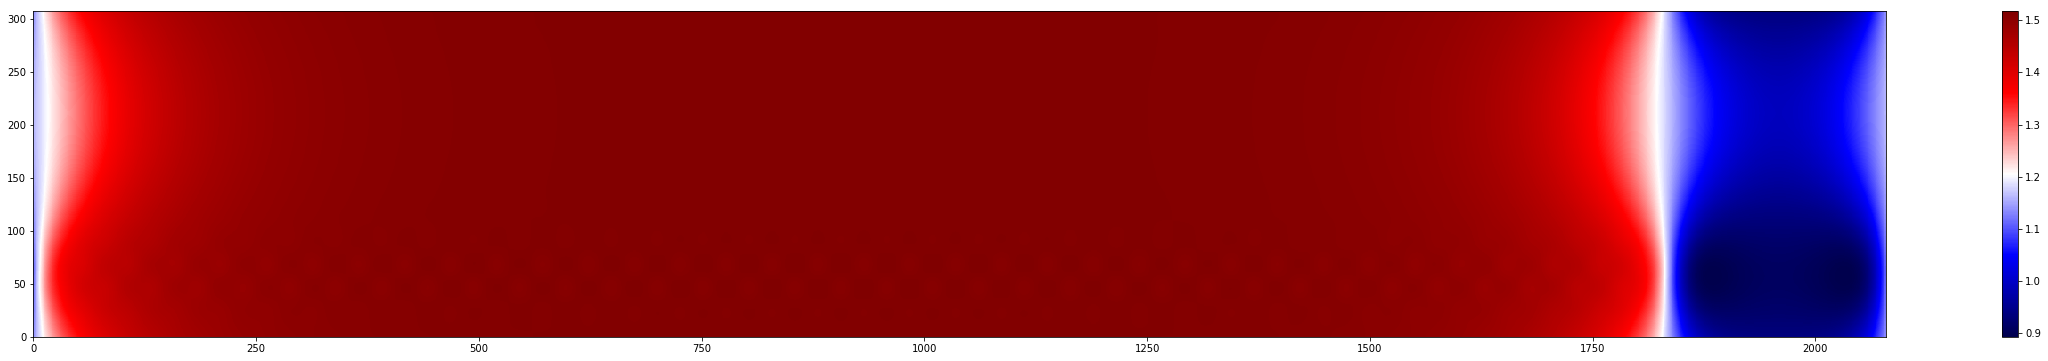

In [32]:
height = 3.0 # angstrom


topmost_atom_z = np.max(hart_atomic_pos[:, 2]) # Angstrom
hart_plane_z = height + topmost_atom_z
hart_plane_index = int(np.round(hart_plane_z/hart_cell[2, 2]*np.shape(hart_cube)[2]))

hart_plane = hart_cube[:, :, hart_plane_index]

print("Hartree on extrapolation plane: min: %.4f; max: %.4f; avg: %.4f (eV)" % (
                                                np.min(hart_plane)*hart_2_ev,
                                                np.max(hart_plane)*hart_2_ev,
                                                np.mean(hart_plane)*hart_2_ev))

fig_size = 6
plt.figure(figsize=(fig_size*hart_plane.shape[0]/hart_plane.shape[1]+1.0, fig_size))
plt.pcolormesh(hart_plane.T*hart_2_ev, cmap='seismic')
plt.colorbar()
plt.show()

In [11]:
hart_plane_index

152

In [8]:
file_cp2k_out = "/home/kristjan/local_work/cnt120-L15-ideal-hartree/cp2k.out"

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Fermi energy: %.6f" % fermi)
print("Read cp2k out: %.3f" % (time.time()-time1))

Fermi energy: -2.841557
Read cp2k out: 0.004


In [9]:
fermi

-2.841557071559961

In [39]:
work_function = np.max(hart_plane)*hart_2_ev - fermi

work_function

4.3599251991427366